In [65]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy import optimize as opt


In [66]:
# Params
a = 1
b = 1
A_p = 314
j = 10**2
K_d = 0.74
K_m = 2.5
k = j/K_d
V_m = 8.8 * 10**3
V = 523
W = 32
y = 0.000083
z = .002
f = 0.1
A_e = 47
g = 0.1


S_e = 10

In [67]:
def bisect_S(P, P_b, E, E_b):
    S = np.linspace(0,20, 10000)
    dSdt = lambda S: -(k/W)*S*((A_p/V)*P(S) + (A_e/V)*E(S)) + (j+a)*((A_p/V)*P_b(S) + (A_e/V)*E_b(S)) - V_m*S / (V*(K_m +S))
    plt.plot(S, dSdt(S))
    plt.ylim((-1,1))
    plt.axhline(y=0, color='r')
    plt.xlabel("S")
    plt.ylabel(r"$\frac{dS}{dt}$")
    plt.legend(["Uracil", "y=0"])
    plt.show()

In [68]:
def eval_fm_alg(S):
    P = (
        S * W * a ** 2 * k * y * z + S * W * a * j * k * y * z + W ** 2 * a ** 2 * b * f * y + W ** 2 * a ** 2 * f * y * z + 2 * W ** 2 * a * b * f * j * y + 2 * W ** 2 * a * f * j * y * z + W ** 2 * b * f * j ** 2 * y + W ** 2 * f * j ** 2 * y * z) / (
        S ** 2 * a ** 2 * k ** 2 * z + S * S_e * W * a ** 2 * k ** 2 * z + S * W * a ** 2 * f * k * z + S * W * a * f * j * k * z + S_e * W ** 2 * a ** 2 * f * k * z + S_e * W ** 2 * a * f * j * k * z)
    Pb = (S * a * k * y * z + W * a * b * f * y + W * a * f * y * z + W * b * f * j * y + W * f * j * y * z) / (
                S * a ** 2 * k * z + W * a ** 2 * f * z + W * a * f * j * z)
    Pu = (S * a * k * y * z + W * a * b * f * y + W * a * f * y * z + W * b * f * j * y + W * f * j * y * z) / (
                S * a * g * k * z + W * a * f * g * z + W * f * g * j * z)
    E = (A_p * W * a * b * y + A_p * W * b * j * y) / (A_e * S * a * k * z + A_e * W * a * f * z + A_e * W * f * j * z)
    Eb = A_p * S * b * k * y / (A_e * S * a * k * z + A_e * W * a * f * z + A_e * W * f * j * z)
    Eu = A_p * y / (A_e * z)

    return [P, Pb, Pu, E, Eb, Eu]

In [69]:
P = lambda S: (S*W*a**2*k*y*z + S*W*a*j*k*y*z + W**2*a**2*b*f*y + W**2*a**2*f*y*z + 2*W**2*a*b*f*j*y + 2*W**2*a*f*j*y*z + W**2*b*f*j**2*y + W**2*f*j**2*y*z)/(S**2*a**2*k**2*z + S*S_e*W*a**2*k**2*z + S*W*a**2*f*k*z + S*W*a*f*j*k*z + S_e*W**2*a**2*f*k*z + S_e*W**2*a*f*j*k*z)
P_b = lambda S: (S*a*k*y*z + W*a*b*f*y + W*a*f*y*z + W*b*f*j*y + W*f*j*y*z)/(S*a**2*k*z + W*a**2*f*z + W*a*f*j*z)
E = lambda S: (A_p*W*a*b*y + A_p*W*b*j*y)/(A_e*S*a*k*z + A_e*W*a*f*z + A_e*W*f*j*z)
E_b = lambda S: A_p*S*b*k*y/(A_e*S*a*k*z + A_e*W*a*f*z + A_e*W*f*j*z)

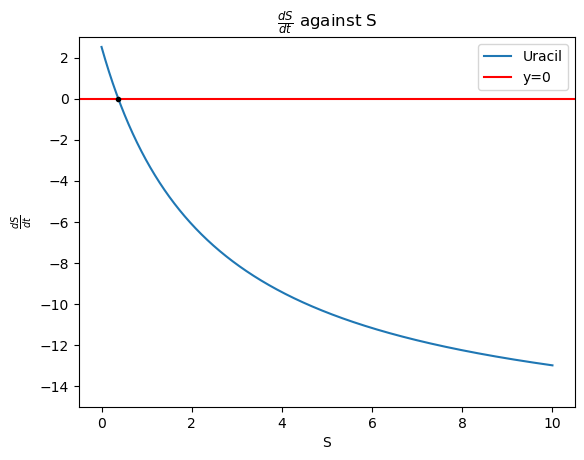

The Steady State of S is:  0.3721458202435315


In [70]:
bisect_S(P, P_b, E, E_b)
dSdt = lambda S: -(k/W)*S*((A_p/V)*P(S) + (A_e/V)*E(S)) + (j+a)*((A_p/V)*P_b(S) + (A_e/V)*E_b(S)) - V_m*S / (V*(K_m +S))
root = opt.bisect(dSdt, 0, 1)

print("The Steady State of S is: ", root)

Compare and Verify

In [71]:
def fm_func(initial_val, t, y, k, S_e, W, j, f, A_e, A_p, a, g, b, z, V_m, V, K_m):
    P, P_b, P_u, E, E_b, E_u, S = initial_val

    dPdt = y - k*S_e*P - (k/W)*S*P + j*P_b + f*(A_e/A_p)*E
    dPbdt = k*S_e*P + (k/W)*S*P - j*P_b - a*P_b
    dPudt = a*P_b - g*P_u
    dEdt = b*E_u - (k/W)*S*E + j*E_b - f*E
    dEbdt = (k/W)*S*E - j*E_b - a*E_b
    dEudt = g*(A_p/A_e)*P_u - b*E_u + a*E_b - z*E_u
    dSdt = -(k/W)*S*((A_p/V)*P + (A_e/V)*E) + (j+a)*((A_p/V)*P_b + (A_e/V)*E_b) - V_m*S / (V*(K_m +S))

    return [dPdt, dPbdt, dPudt, dEdt, dEbdt, dEudt, dSdt]


t_range = np.linspace(0, 400000, 100000)
initial_val = [1,0,0,0,0,0,0]
num_sol = odeint(fm_func, y0=initial_val, t=t_range, args=(y, k, S_e, W, j, f, A_e, A_p, a, g, b, z, V_m, V, K_m))[-1]


print("Uracil: ", np.allclose(root, num_sol[-1]))

Uracil:  True
